# 生成训练数据

In [49]:
import pysam
import heapq
import random
import numpy as np
import scipy
import h5py
from collections import namedtuple

import warnings
warnings.filterwarnings("ignore")

import cooler
import cooltools

from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan

from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [3]:
fasta_files = "/home/sun/data/genome_index/bwa/hg38/hg38.fa"
gaps_file = "/home/sun/data/work/akita/results/coolers_library/hg38.mapq_30.2048_gaps.bed"
hic_file = "/home/sun/data/work/akita/results/coolers_library/fx/data/HFF_hg38_4DNFIP5EUOFX.mapq_30.2048.cool"
seq_length = 1048576

In [30]:
##process funtion

onehot_nuc = {'A':[1,0,0,0],
            'C':[0,1,0,0],
            'G':[0,0,1,0],
            'T':[0,0,0,1],
            'N':[0,0,0,0]}
def onehot_seq(seq):
    return np.array([onehot_nuc[nuc] for nuc in str(seq).upper()])

def load_chromosomes(genome_file):
    """ Load genome segments from either a FASTA file or
          chromosome length table. """
    chrom_segments = {}
    fasta_open = pysam.Fastafile(genome_file)
    for i in range(len(fasta_open.references)):
        chrom_segments[fasta_open.references[i]] = [(0, fasta_open.lengths[i])]
    fasta_open.close()

    return chrom_segments


def split_contigs(chrom_segments, gaps_file):
    """ Split the assembly up into contigs defined by the gaps.
  Args:
    chrom_segments: dict mapping chromosome names to lists of (start,end)
    gaps_file: file specifying assembly gaps
  Returns:
    chrom_segments: same, with segments broken by the assembly gaps.
  """
    chrom_events = {}

    # add known segments
    for chrom in chrom_segments:
        cstart, cend = chrom_segments[chrom][0]
        chrom_events.setdefault(chrom, []).append((cstart, "Cstart"))
        chrom_events[chrom].append((cend, "cend"))

    # add gaps
    for line in open(gaps_file):
        a = line.split()
        chrom = a[0]
        gstart = int(a[1])
        gend = int(a[2])

        if chrom in chrom_events:
            chrom_events[chrom].append((gstart, "gstart"))
            chrom_events[chrom].append((gend, "gend"))

    for chrom in chrom_events:
        # sort
        chrom_events[chrom].sort()

        # read out segments
        chrom_segments[chrom] = []
        for i in range(len(chrom_events[chrom]) - 1):
            pos1, event1 = chrom_events[chrom][i]
            pos2, event2 = chrom_events[chrom][i + 1]

            event1 = event1.lower()
            event2 = event2.lower()

            shipit = False
            if event1 == 'cstart' and event2 == 'cend':
                shipit = True
            elif event1 == 'cstart' and event2 == 'gstart':
                shipit = True
            elif event1 == 'gend' and event2 == 'gstart':
                shipit = True
            elif event1 == 'gend' and event2 == 'cend':
                shipit = True
            elif event1 == 'gstart' and event2 == 'gend':
                pass
            else:
                pass

            if shipit and pos1 < pos2:
                chrom_segments[chrom].append((pos1, pos2))

    return chrom_segments


def break_large_contigs(contigs, break_t, verbose=False):
    """Break large contigs in half until all contigs are under
       the size threshold."""

    # initialize a heapq of contigs and lengths
    contig_heapq = []
    for ctg in contigs:
        ctg_len = ctg.end - ctg.start
        heapq.heappush(contig_heapq, (-ctg_len, ctg))

    ctg_len = break_t + 1
    while ctg_len > break_t:

        # pop largest contig
        ctg_nlen, ctg = heapq.heappop(contig_heapq)
        ctg_len = -ctg_nlen

        # if too large
        if ctg_len > break_t:
            if verbose:
                print('Breaking %s:%d-%d (%d nt)' % (ctg.chr, ctg.start, ctg.end, ctg_len))

            # break in two
            ctg_mid = ctg.start + ctg_len // 2

            try:
                ctg_left = Contig(ctg.genome, ctg.chr, ctg.start, ctg_mid)
                ctg_right = Contig(ctg.genome, ctg.chr, ctg_mid, ctg.end)
            except AttributeError:
                ctg_left = Contig(ctg.chrom, ctg.start, ctg_mid)
                ctg_right = Contig(ctg.chrom, ctg_mid, ctg.end)

            # add left
            ctg_left_len = ctg_left.end - ctg_left.start
            heapq.heappush(contig_heapq, (-ctg_left_len, ctg_left))

            # add right
            ctg_right_len = ctg_right.end - ctg_right.start
            heapq.heappush(contig_heapq, (-ctg_right_len, ctg_right))

    # return to list
    contigs = [len_ctg[1] for len_ctg in contig_heapq]

    return contigs


def divide_contigs_pct(contigs, test_pct, valid_pct, pct_abstain=0.2):
    """Divide list of contigs into train/valid/test lists,
       aiming for the specified nucleotide percentages."""

    # sort contigs descending by length
    length_contigs = [(ctg.end - ctg.start, ctg) for ctg in contigs]
    length_contigs.sort(reverse=True)

    # compute total nucleotides
    total_nt = sum([lc[0] for lc in length_contigs])

    # compute aimed train/valid/test nucleotides
    test_nt_aim = test_pct * total_nt
    valid_nt_aim = valid_pct * total_nt
    train_nt_aim = total_nt - valid_nt_aim - test_nt_aim

    # initialize current train/valid/test nucleotides
    train_nt = 0
    valid_nt = 0
    test_nt = 0

    # initialize train/valid/test contig lists
    train_contigs = []
    valid_contigs = []
    test_contigs = []

    # process contigs
    for ctg_len, ctg in length_contigs:

        # compute gap between current and aim
        test_nt_gap = max(0, test_nt_aim - test_nt)
        valid_nt_gap = max(0, valid_nt_aim - valid_nt)
        train_nt_gap = max(1, train_nt_aim - train_nt)

        # skip if too large
        if ctg_len > pct_abstain * test_nt_gap:
            test_nt_gap = 0
        if ctg_len > pct_abstain * valid_nt_gap:
            valid_nt_gap = 0

        # compute remaining %
        gap_sum = train_nt_gap + valid_nt_gap + test_nt_gap
        test_pct_gap = test_nt_gap / gap_sum
        valid_pct_gap = valid_nt_gap / gap_sum
        train_pct_gap = train_nt_gap / gap_sum

        # sample train/valid/test
        ri = np.random.choice(range(3), 1, p=[train_pct_gap, valid_pct_gap, test_pct_gap])[0]
        if ri == 0:
            train_contigs.append(ctg)
            train_nt += ctg_len
        elif ri == 1:
            valid_contigs.append(ctg)
            valid_nt += ctg_len
        elif ri == 2:
            test_contigs.append(ctg)
            test_nt += ctg_len
        else:
            print('TVT random number beyond 0,1,2', file=sys.stderr)
            exit(1)

    print('Contigs divided into')
    print(' Train: %5d contigs, %10d nt (%.4f)' % \
          (len(train_contigs), train_nt, train_nt / total_nt))
    print(' Valid: %5d contigs, %10d nt (%.4f)' % \
          (len(valid_contigs), valid_nt, valid_nt / total_nt))
    print(' Test:  %5d contigs, %10d nt (%.4f)' % \
          (len(test_contigs), test_nt, test_nt / total_nt))

    return [train_contigs, valid_contigs, test_contigs]


def rejoin_large_contigs(contigs):
    """ Rejoin large contigs that were broken up before alignment comparison."""

    # split list by chromosome
    chr_contigs = {}
    for ctg in contigs:
        chr_contigs.setdefault(ctg.chrom, []).append(ctg)

    contigs = []
    for chrm in chr_contigs:
        # sort within chromosome
        chr_contigs[chrm].sort(key=lambda x: x.start)

        ctg_ongoing = chr_contigs[chrm][0]
        for i in range(1, len(chr_contigs[chrm])):
            ctg_this = chr_contigs[chrm][i]
            if ctg_ongoing.end == ctg_this.start:
                # join
                # ctg_ongoing.end = ctg_this.end
                ctg_ongoing = ctg_ongoing._replace(end=ctg_this.end)
            else:
                # conclude ongoing
                contigs.append(ctg_ongoing)

                # move to next
                ctg_ongoing = ctg_this

        # conclude final
        contigs.append(ctg_ongoing)

    return contigs


def contig_sequences(contigs, seq_length, stride, snap=1, label=None):
    ''' Break up a list of Contig's into a list of ModelSeq's. '''
    mseqs = []
    for ctg in contigs:
        seq_start = int(np.ceil(ctg.start / snap) * snap)
        seq_end = seq_start + seq_length

        while seq_end <= ctg.end:
            # record sequence
            mseqs.append(ModelSeq(ctg.chrom, seq_start, seq_end, label))

            # update
            seq_start += stride
            seq_end += stride

    return mseqs


In [6]:
chrom_contigs = load_chromosomes(fasta_files)

In [7]:
##remove gaps
chrom_contigs = split_contigs(chrom_contigs,gaps_file)
Contig = namedtuple("Contig",["chrom","start","end"])

In [8]:
contigs = []
for chrom in chrom_contigs:
    contigs += [Contig(chrom,start,end) for start,end in chrom_contigs[chrom]]

In [9]:
len(contigs)

1310

In [10]:
## filter for large enough
contigs = [ctg for ctg in contigs if ctg.end - ctg.start >= 1048576]

In [11]:
##break large contig
contigs = break_large_contigs(contigs,1048576)

In [12]:
## divide between train/valid/test
fold_labels = ['train', 'valid', 'test']
num_folds = 3
fold_contigs = divide_contigs_pct(contigs, 0.1, 0.1)

Contigs divided into
 Train:  3092 contigs, 2216160567 nt (0.8017)
 Valid:   379 contigs,  274011856 nt (0.0991)
 Test:    380 contigs,  274254114 nt (0.0992)


In [13]:
#rejoin broken contigs within set
for fi in range(len(fold_contigs)):
    fold_contigs[fi] = rejoin_large_contigs(fold_contigs[fi])

In [14]:
# define model sequences
ModelSeq = namedtuple("ModelSeq",["chrom","seq_start", "seq_end", "label"])
fold_mseqs = []
for fi in range(3):
    if fold_labels[fi] in ['valid','test']:
        stride_fold = 2**19
    else:
        stride_fold = 2**18
    fold_mseqs_fi = contig_sequences(fold_contigs[fi], 1048576,
                                       stride_fold, 1, fold_labels[fi])
    fold_mseqs.append(fold_mseqs_fi)
    random.shuffle(fold_mseqs[fi])
    
    if 0.05 < 1.0:
        fold_mseqs[fi] = random.sample(fold_mseqs[fi], int(0.05*len(fold_mseqs[fi])))

mseqs = [ms for fm in fold_mseqs for ms in fm]

    # stride sequences across contig

## map hic and sequence

In [35]:
clr = cooler.Cooler(hic_file)
fasta_open = pysam.Fastafile(fasta_files)

In [20]:
##计算维度
num_seqs = len(mseqs)
seq_len_nt = mseqs[0].seq_end - mseqs[0].seq_start
seq_len_pool = seq_len_nt // 2048

#计算裁剪尺寸---bin
crop_start = 65536 // 2048
crop_end = seq_len_pool - crop_start
seq_len_crop = seq_len_pool - 2*crop_start

##计算上三角矩阵，并排除第一对角线和第二对角线的值
triu_tup = np.triu_indices(seq_len_crop, 2)
seq_len_nodiag = seq_len_crop - 2
seq_len_hic = seq_len_nodiag*(seq_len_nodiag + 1) // 2


In [37]:
##数据保存路径
train_dataset = h5py.File("train.h5","w")
test_dataset = h5py.File("test.h5","w")
valid_dataset = h5py.File("valid.h5","w")

In [51]:
train_sequence_ls = []
train_target_ls = []
valid_sequence_ls = []
valid_target_ls = []
test_sequence_ls = []
test_target_ls = []
##读取每条数据
tqnm = len(mseqs)

for index,mseq in enumerate(mseqs):
    if mseq.chrom in clr.chromnames:
        mseq_str = '%s:%d-%d' % (mseq.chrom, mseq.seq_start, mseq.seq_end)
        seq_hic_raw = clr.matrix(balance=True).fetch(mseq_str)
        seq_hic_nan = np.isnan(seq_hic_raw)
        # clip first diagonals and high values
        clipval = np.nanmedian(np.diag(seq_hic_raw,2))
        for i in range(-2+1,2):
            set_diag(seq_hic_raw, clipval, i)
        seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
        seq_hic_raw[seq_hic_nan] = np.nan

        ##自适应
        seq_hic_smoothed = adaptive_coarsegrain(
                          seq_hic_raw,
                          clr.matrix(balance=False).fetch(mseq_str),
                          cutoff=2, max_levels=8)
        seq_hic_nan = np.isnan(seq_hic_smoothed)

        ##obs/exp
        seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
        seq_hic_obsexp = np.log(seq_hic_obsexp)
        seq_hic_obsexp = np.clip(seq_hic_obsexp, -2, 2)
        seq_hic_obsexp = interp_nan(seq_hic_obsexp)
        for i in range(-2+1, 2): set_diag(seq_hic_obsexp, 0,i)

        #插值
        kernel = Gaussian2DKernel(x_stddev=1,x_size=5)
        seq_hic = convolve(seq_hic_obsexp, kernel)
        seq_hic = seq_hic[crop_start:crop_end,:]
        seq_hic = seq_hic[:,crop_start:crop_end]

        ##处理序列
        seq_dna = fasta_open.fetch(mseq.chrom, mseq.seq_start, mseq.seq_end)
        seq_1hot = onehot_seq(seq_dna)
        if mseq.label == "train":
            train_sequence_ls.append(seq_1hot)
            train_target_ls.append(seq_hic)
        if mseq.label == "valid":
            valid_sequence_ls.append(seq_1hot)
            valid_target_ls.append(seq_hic)
        if mseq.label == "test":
            test_sequence_ls.append(seq_1hot)
            test_target_ls.append(seq_hic)
        print(f"当前处理[{index}/{tqnm}],序列长度:{mseq.seq_end-mseq.seq_start}")

当前处理[0/295],序列长度:1048576
当前处理[1/295],序列长度:1048576
当前处理[2/295],序列长度:1048576
当前处理[3/295],序列长度:1048576
当前处理[4/295],序列长度:1048576
当前处理[5/295],序列长度:1048576
当前处理[6/295],序列长度:1048576
当前处理[7/295],序列长度:1048576
当前处理[8/295],序列长度:1048576
当前处理[9/295],序列长度:1048576
当前处理[10/295],序列长度:1048576
当前处理[11/295],序列长度:1048576
当前处理[12/295],序列长度:1048576
当前处理[13/295],序列长度:1048576
当前处理[14/295],序列长度:1048576
当前处理[16/295],序列长度:1048576
当前处理[17/295],序列长度:1048576
当前处理[18/295],序列长度:1048576
当前处理[19/295],序列长度:1048576
当前处理[20/295],序列长度:1048576
当前处理[21/295],序列长度:1048576
当前处理[22/295],序列长度:1048576
当前处理[23/295],序列长度:1048576
当前处理[24/295],序列长度:1048576
当前处理[25/295],序列长度:1048576
当前处理[26/295],序列长度:1048576
当前处理[27/295],序列长度:1048576
当前处理[28/295],序列长度:1048576
当前处理[29/295],序列长度:1048576
当前处理[30/295],序列长度:1048576
当前处理[31/295],序列长度:1048576
当前处理[32/295],序列长度:1048576
当前处理[33/295],序列长度:1048576
当前处理[34/295],序列长度:1048576
当前处理[35/295],序列长度:1048576
当前处理[36/295],序列长度:1048576
当前处理[37/295],序列长度:1048576
当前处理[38/295],序列长度:1048576
当前处理[39/295],序列长度:1048

In [63]:
for i in mseqs:
    if i.chrom == "chr12":
        print(i)

ModelSeq(chrom='chr12', seq_start=102303744, seq_end=103352320, label='train')
ModelSeq(chrom='chr12', seq_start=49585152, seq_end=50633728, label='train')
ModelSeq(chrom='chr12', seq_start=104400896, seq_end=105449472, label='train')
ModelSeq(chrom='chr12', seq_start=26445824, seq_end=27494400, label='train')
ModelSeq(chrom='chr12', seq_start=48798720, seq_end=49847296, label='train')
ModelSeq(chrom='chr12', seq_start=53872640, seq_end=54921216, label='train')
ModelSeq(chrom='chr12', seq_start=90722304, seq_end=91770880, label='train')
ModelSeq(chrom='chr12', seq_start=32450048, seq_end=33498624, label='train')
ModelSeq(chrom='chr12', seq_start=106192576, seq_end=107241152, label='train')
ModelSeq(chrom='chr12', seq_start=93343744, seq_end=94392320, label='train')
ModelSeq(chrom='chr12', seq_start=84709376, seq_end=85757952, label='train')
ModelSeq(chrom='chr12', seq_start=1218560, seq_end=2267136, label='train')
ModelSeq(chrom='chr12', seq_start=87838720, seq_end=88887296, label='tra

In [60]:
train_target_ls[40]

array([[-0.00511567,  0.00795039,  0.02363746, ..., -0.76337986,
        -0.75583554, -0.72959901],
       [ 0.00795039,  0.01563653,  0.01300704, ..., -0.81352452,
        -0.78556713, -0.72647595],
       [ 0.02363746,  0.01300704, -0.00206015, ..., -0.88025795,
        -0.80697351, -0.72746925],
       ...,
       [-0.76337986, -0.81352452, -0.88025795, ..., -0.03050815,
        -0.02481802,  0.01585894],
       [-0.75583554, -0.78556713, -0.80697351, ..., -0.02481802,
         0.0038386 ,  0.03182702],
       [-0.72959901, -0.72647595, -0.72746925, ...,  0.01585894,
         0.03182702,  0.02599485]])

In [57]:
len(train_sequence_ls)

288

In [52]:
train_dataset["data"] = train_sequence_ls
train_dataset["label"] = train_target_ls

In [53]:
train_dataset.close()

## 可视化

In [25]:
import matplotlib.pyplot as plt

In [21]:
seq_hic = seq_hic[triu_tup]

In [54]:
seq_hic.shape

(448, 448)

In [22]:
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [23]:
arrm = from_upper_triu(seq_hic,448,2)

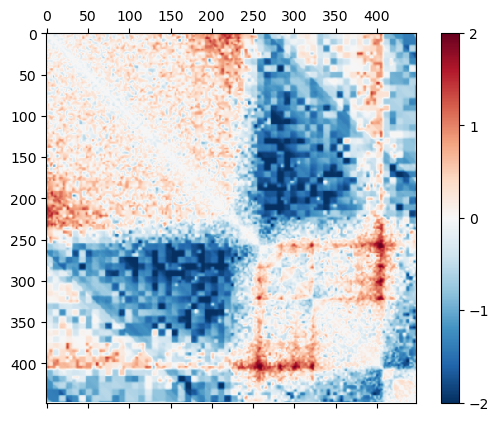

In [61]:
im = plt.matshow(train_target_ls[40], fignum=False, cmap= 'RdBu_r', vmax=2, vmin=-2)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
# plt.title( 'target-'+str(hic_num_to_name_dict[target_index]),y=1.15)